<a href="https://colab.research.google.com/github/aadityacs/PolyTO/blob/main/poly_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
from typing import Tuple
import numpy as np
import jax.numpy as jnp
from jax import value_and_grad
import jax
import matplotlib.pyplot as plt

import mesher
import examples
import poly_primitives as poly
import geometry_projection as gp
import FE_routines as fe
import mma
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [31]:
bounding_box = mesher.BoundingBox(x_min=0., x_max=60.,
                                  y_min=0., y_max = 30.)
mesh = mesher.Mesher(nelx = 40, nely = 20, bounding_box=bounding_box)

# plot on a higher res mesh
plot_mesh = mesher.Mesher(nelx = 600, nely = 300, bounding_box=bounding_box)

In [32]:
material = fe.Material(youngs_modulus=1.,
                       poissons_ratio=0.3,
                       delta_youngs_modulus=1e-3)

In [33]:
bc = examples.get_sample_bc(mesh, examples.SampleBoundaryConditions.MBB_BEAM)

In [34]:
nxb, nyb = 3, 2
num_polys = nxb*nyb
num_planes_in_a_poly = 6
max_angle_offset = 2*np.pi
poly_extents = poly.PolygonExtents(num_polys=num_polys,
                          num_planes_in_a_poly=num_planes_in_a_poly,
                          min_center_x=-0.,
                          min_center_y=-0., 
                          max_center_x=mesh.lx,
                          max_center_y=mesh.ly,
                          min_face_offset=-0.1*mesh.lx,
                          max_face_offset=0.5*mesh.lx,
                          min_angle_offset=0.,
                          max_angle_offset= max_angle_offset)

In [35]:
# init_geom = poly.init_random_polys(poly_extents)
init_geom = poly.init_poly_grid(nxb, nyb, poly_extents)

In [36]:
fe_solver = fe.FEA(mesh, material, bc)
lossfn = fe_solver.loss_function

In [39]:
def plot_polygons(polygons: poly.ConvexPolys, mesh: mesher.Mesher,
                  status = '', save_fig_as = None):
  """
  Each blob gets a different random color.
  """
  
  # get the density of each blob
  sdf = poly.compute_poly_sdf(polygons, mesh)
  density = gp.project_primitive_sdf_to_density(sdf, mesh, 100)

  red_color = np.zeros((density.shape[0], 4))
  red_color[:,0] = 1.; red_color[:,1] = 0.
  red_color[:,2] = 0.; red_color[:,3] = 0.5

  grayness = 0.98 # bg color to slight gray
  composite_img = ( np.clip(
    np.einsum('bc, be -> ec', red_color, density), a_min=0.05, a_max=grayness))

  plt.figure()
  plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)
  plt.imshow(composite_img.reshape((mesh.nelx, mesh.nely, 4)).transpose((1, 0, 2)),
            origin='lower')
  plt.axis('off')
  plt.title(status)
  
  if save_fig_as is not None:
    plt.savefig(save_fig_as)
  plt.show()

def polygons_to_density(polygons: poly.ConvexPolys, mesh: mesher.Mesher):
  sdf = poly.compute_poly_sdf(polygons, mesh)
  density = gp.project_primitive_sdf_to_density(sdf, mesh)
  return gp.compute_union_density_fields(density)

class Optimizer:
  def __init__(self, lossfn: callable,
               mesh: mesher.Mesher,
               polyg_extents: poly.PolygonExtents):
    self.lossfn, self.mesh = lossfn, mesh
    self.polyg_extents = polyg_extents
  #-----------------------#
  def constraint_fn(self, design_variable: jnp.ndarray,
                        max_vol_frac: float,
                        allowed_min_edge_length: float) -> Tuple[jnp.ndarray, jnp.ndarray]:

    def volume_constraint(design_variable:jnp.ndarray)-> float:
      self.geometry = poly.ConvexPolys.from_normalized_array(
            design_variable.reshape((-1)), self.polyg_extents)
      density = polygons_to_density(self.geometry, self.mesh)
      occupied_volume = self.mesh.elem_area*jnp.sum(density)
      volcons =  occupied_volume/(max_vol_frac*self.mesh.domain_volume) - 1.
      return volcons
    vc, dvc = value_and_grad(volume_constraint)(design_variable)

    def min_edge_length_constraint(design_variable:jnp.ndarray)-> float:
      polygons = poly.ConvexPolys.from_normalized_array(
            design_variable.reshape((-1)), self.polyg_extents)
      min_edge_length = poly.compute_min_edge_length_of_polygons(polygons)
      return 1. - (min_edge_length/allowed_min_edge_length)
    elc, delc = value_and_grad(min_edge_length_constraint)(design_variable)
    
    c = jnp.vstack((vc, elc))
    dc = jnp.hstack((dvc, delc)).T
    return c, dc
  #-----------------------#
  def objective_fn(self, design_var: jnp.ndarray)-> Tuple[jnp.ndarray,
                                                          jnp.ndarray]:
    def obj_wrapper(design_var: jnp.ndarray)->jnp.ndarray:
      self.geometry = poly.ConvexPolys.from_normalized_array(
        design_var.reshape((-1)), self.polyg_extents)
      density = polygons_to_density(self.geometry, self.mesh)
      compliance = self.lossfn(density)
      return compliance
    obj, grad_obj = value_and_grad(obj_wrapper)(design_var)
    return obj, grad_obj.reshape((-1, 1))
  #-----------------------#
  def optimize(self, init_geom: poly.ConvexPolys,
               max_vol_frac: float, allowed_min_edge_length: float,
               max_iter: int,
               kkt_tol: float=1e-6, step_tol: float=1e-6, move_limit: float=1e-2,
               plot_interval: int=5):

    self.num_design_var = init_geom.num_free_parameters
    self.geometry = init_geom
    self.design_var = self.geometry.to_normalized_array(
      self.polyg_extents).reshape((-1, 1))
    lower_bound = np.zeros((self.num_design_var, 1))
    upper_bound = np.ones((self.num_design_var, 1))
    mma_params = mma.MMAParams(
        max_iter=max_iter,
        kkt_tol=kkt_tol,
        step_tol=step_tol,
        move_limit=move_limit,
        num_design_var=self.num_design_var,
        num_cons=2,
        lower_bound=lower_bound,
        upper_bound=upper_bound,
    )
    mma_state = mma.init_mma(self.design_var, mma_params)
    def plotfun(x, status = ''):
      polygons = poly.ConvexPolys.from_normalized_array(
                    x.reshape((-1)), self.polyg_extents)
      plot_polygons(polygons, plot_mesh, status=status,
                    save_fig_as = f'./frames/iter_{mma_state.epoch}.svg')

    history = {'obj':[], 'vol_cons':[], 'edge_len_cons':[]}

    while not mma_state.is_converged:
      objective, grad_obj = self.objective_fn(mma_state.x)
      constr, grad_cons = self.constraint_fn(mma_state.x, max_vol_frac,
                                             allowed_min_edge_length)
      mma_state.x = np.array(mma_state.x)
      mma_state = mma.update_mma(
        mma_state, mma_params, np.array(objective),
        np.array(grad_obj), np.array(constr), np.array(grad_cons)
      )

      status = (f'epoch {mma_state.epoch:d} obj {objective:.2E} '
                f'vol cons {constr[0,0]:.2E} edge_len_cons {constr[1,0]:.2E} ')
      history['obj'].append(objective)
      history['vol_cons'].append(constr[0,0])
      history['edge_len_cons'].append(constr[1,0])
      
      print(status)
      if mma_state.epoch%plot_interval == 0 or mma_state.epoch==1:
        plotfun(mma_state.x, status)
    return mma_state, history

epoch 1 obj 3.29E+03 vol cons -6.75E-01 edge_len_cons -1.09E+00 


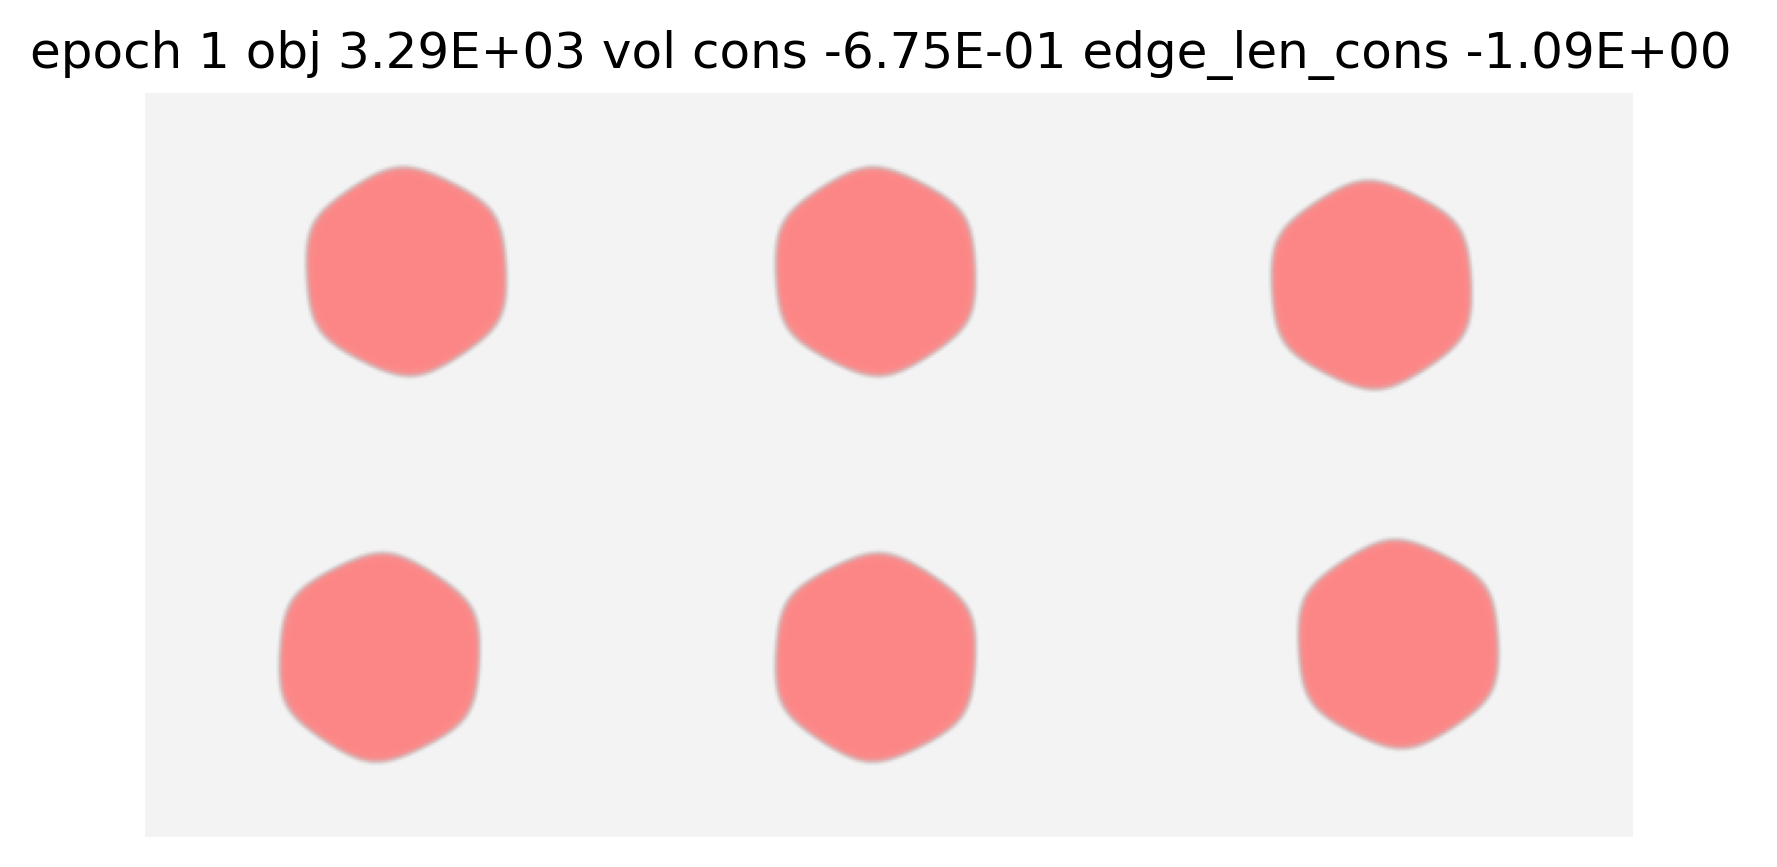

epoch 2 obj 3.09E+03 vol cons -6.16E-01 edge_len_cons -1.27E+00 
epoch 3 obj 2.86E+03 vol cons -5.53E-01 edge_len_cons -1.45E+00 
epoch 4 obj 2.56E+03 vol cons -4.78E-01 edge_len_cons -1.65E+00 
epoch 5 obj 2.26E+03 vol cons -3.98E-01 edge_len_cons -1.85E+00 
epoch 6 obj 1.97E+03 vol cons -3.15E-01 edge_len_cons -2.05E+00 
epoch 7 obj 1.60E+03 vol cons -2.32E-01 edge_len_cons -2.25E+00 
epoch 8 obj 1.33E+03 vol cons -1.55E-01 edge_len_cons -2.45E+00 
epoch 9 obj 1.05E+03 vol cons -7.98E-02 edge_len_cons -2.65E+00 
epoch 10 obj 6.98E+02 vol cons -3.35E-02 edge_len_cons -2.61E+00 
epoch 11 obj 5.04E+02 vol cons -2.82E-02 edge_len_cons -2.35E+00 
epoch 12 obj 4.23E+02 vol cons -1.93E-02 edge_len_cons -2.15E+00 
epoch 13 obj 3.33E+02 vol cons -1.97E-02 edge_len_cons -1.91E+00 
epoch 14 obj 2.94E+02 vol cons -1.85E-02 edge_len_cons -1.69E+00 
epoch 15 obj 2.59E+02 vol cons -2.04E-02 edge_len_cons -1.36E+00 
epoch 16 obj 2.28E+02 vol cons -1.55E-02 edge_len_cons -1.13E+00 
epoch 17 obj 2.04E

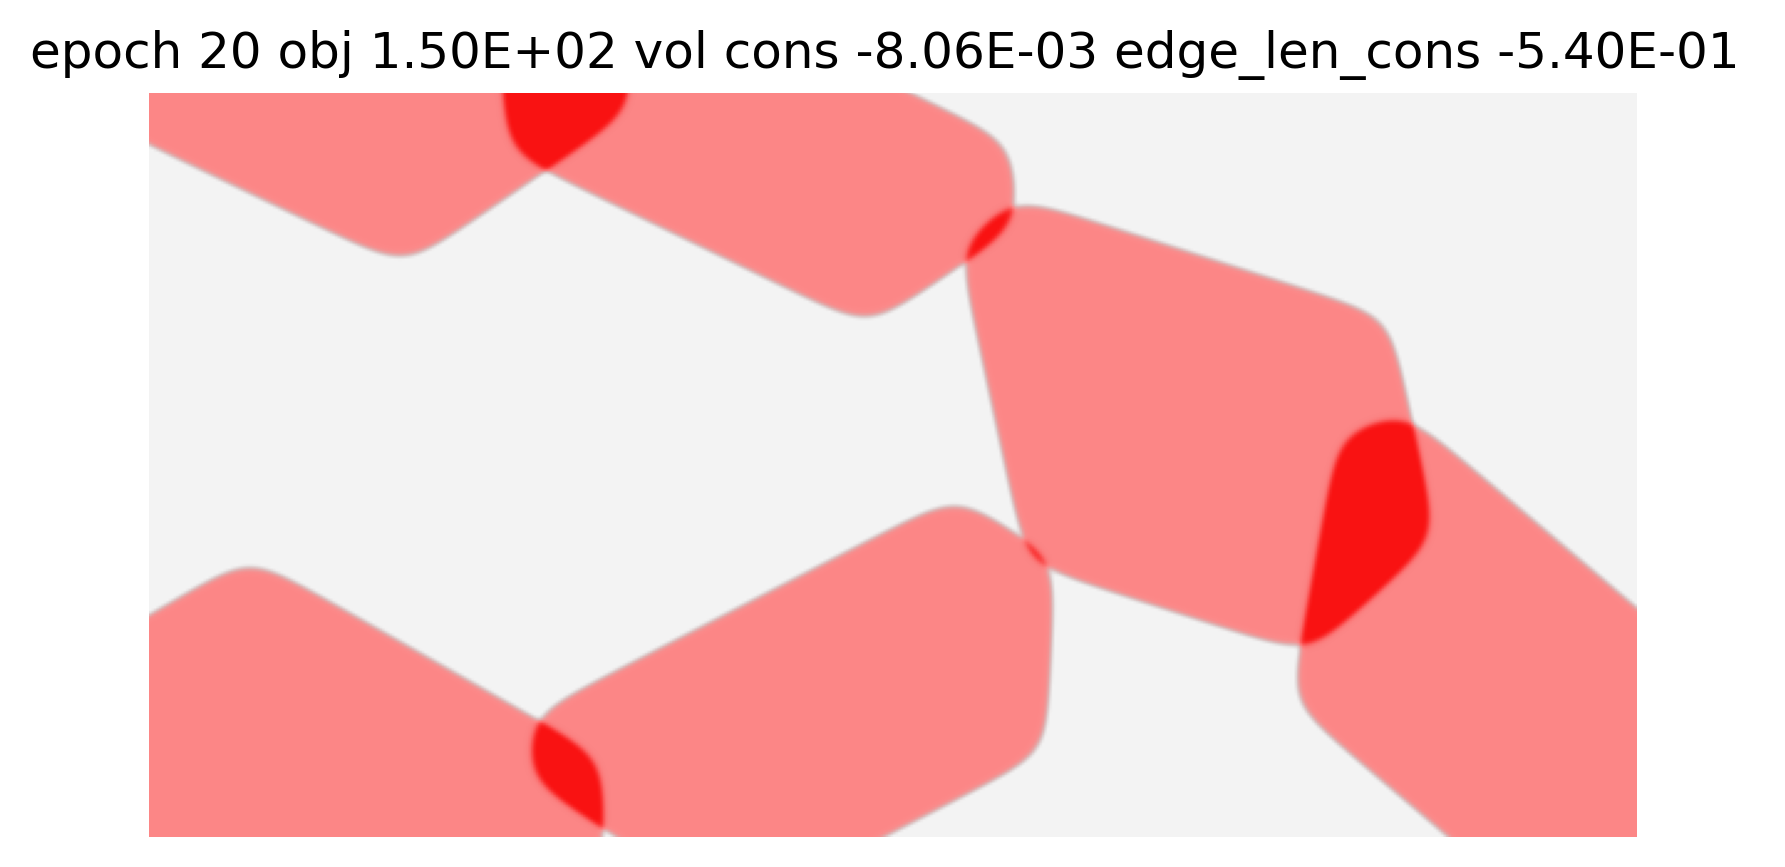

In [42]:
optim = Optimizer(lossfn, mesh, poly_extents)

mma_state, history = optim.optimize(init_geom, max_vol_frac=0.5,
                                    allowed_min_edge_length = 2.,
                                    max_iter=20,
                                    plot_interval=20)
plt.show(block=True)

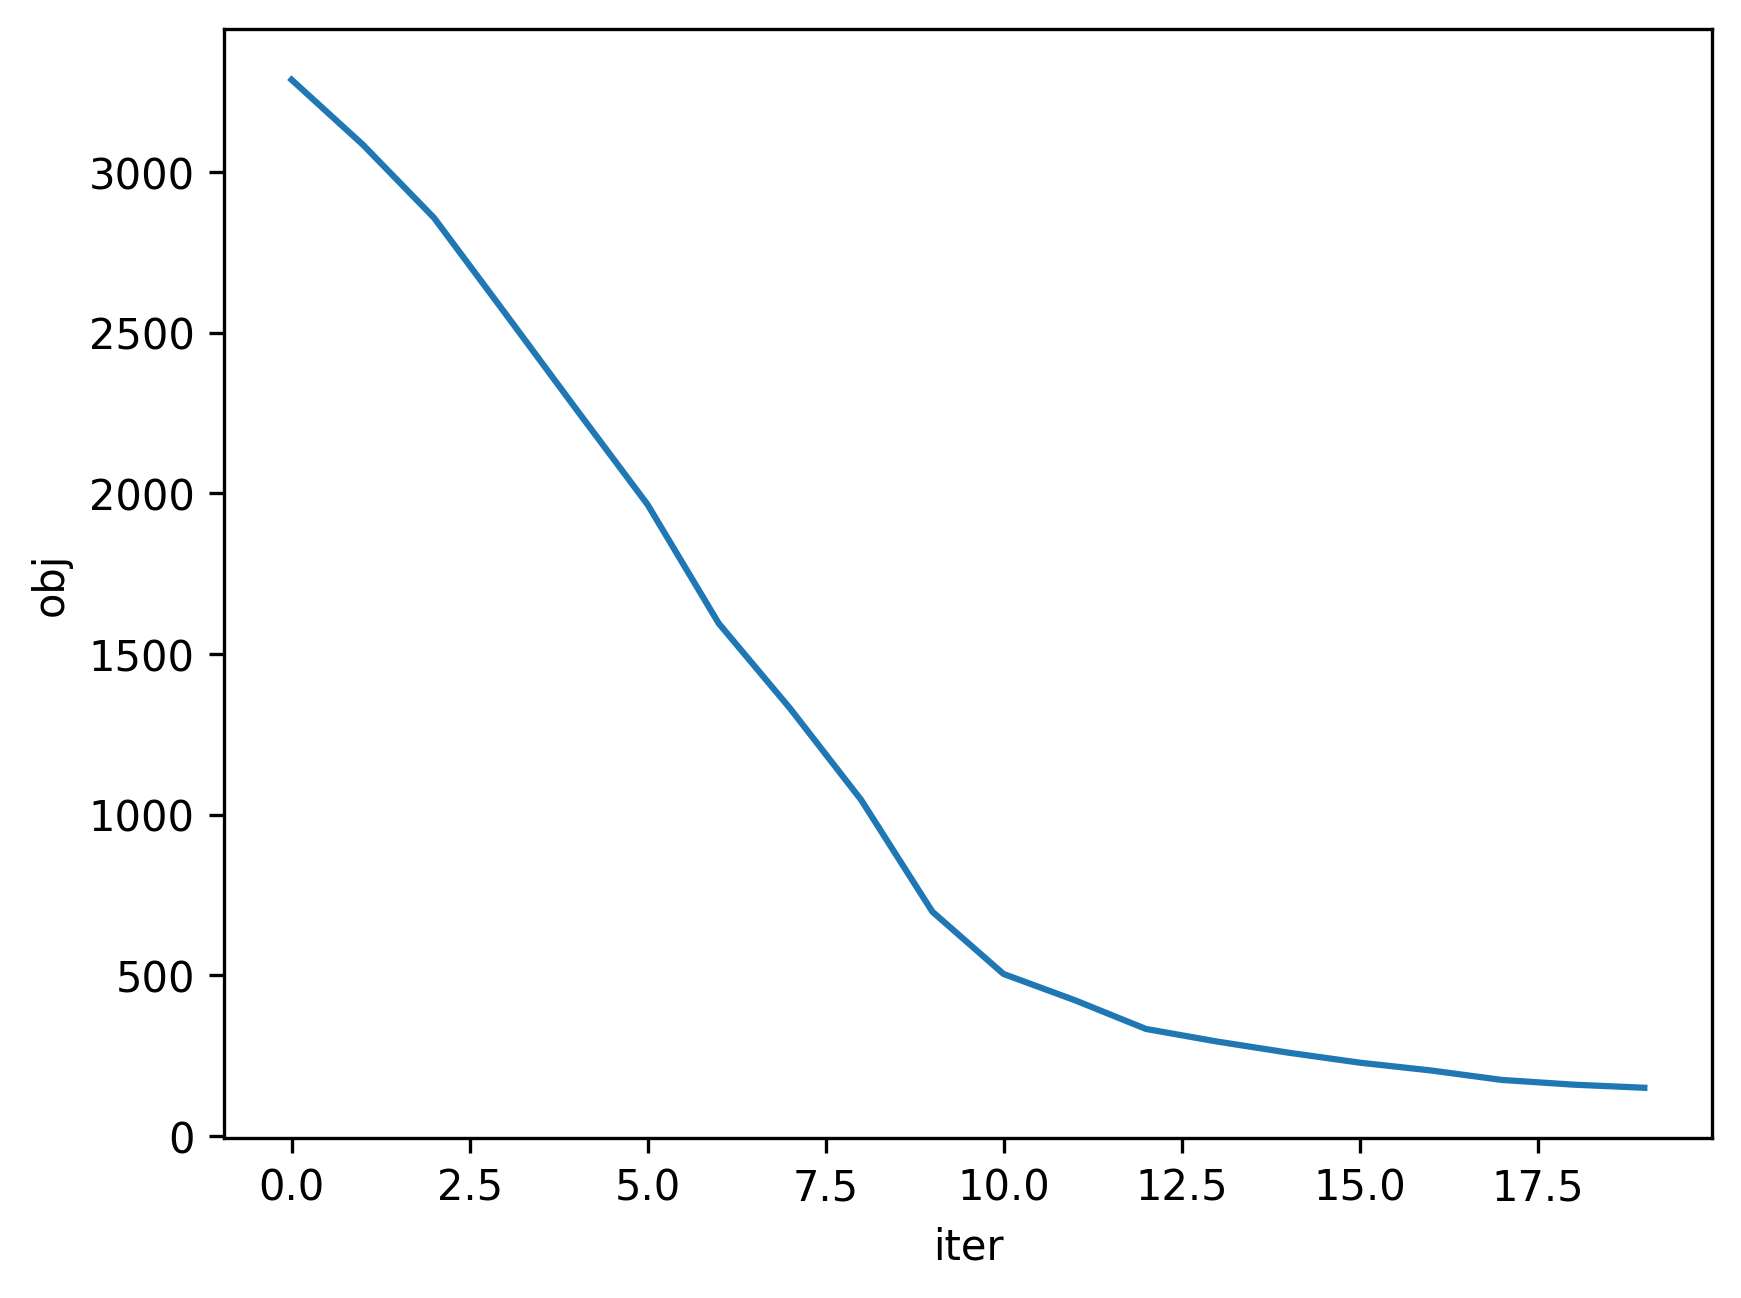

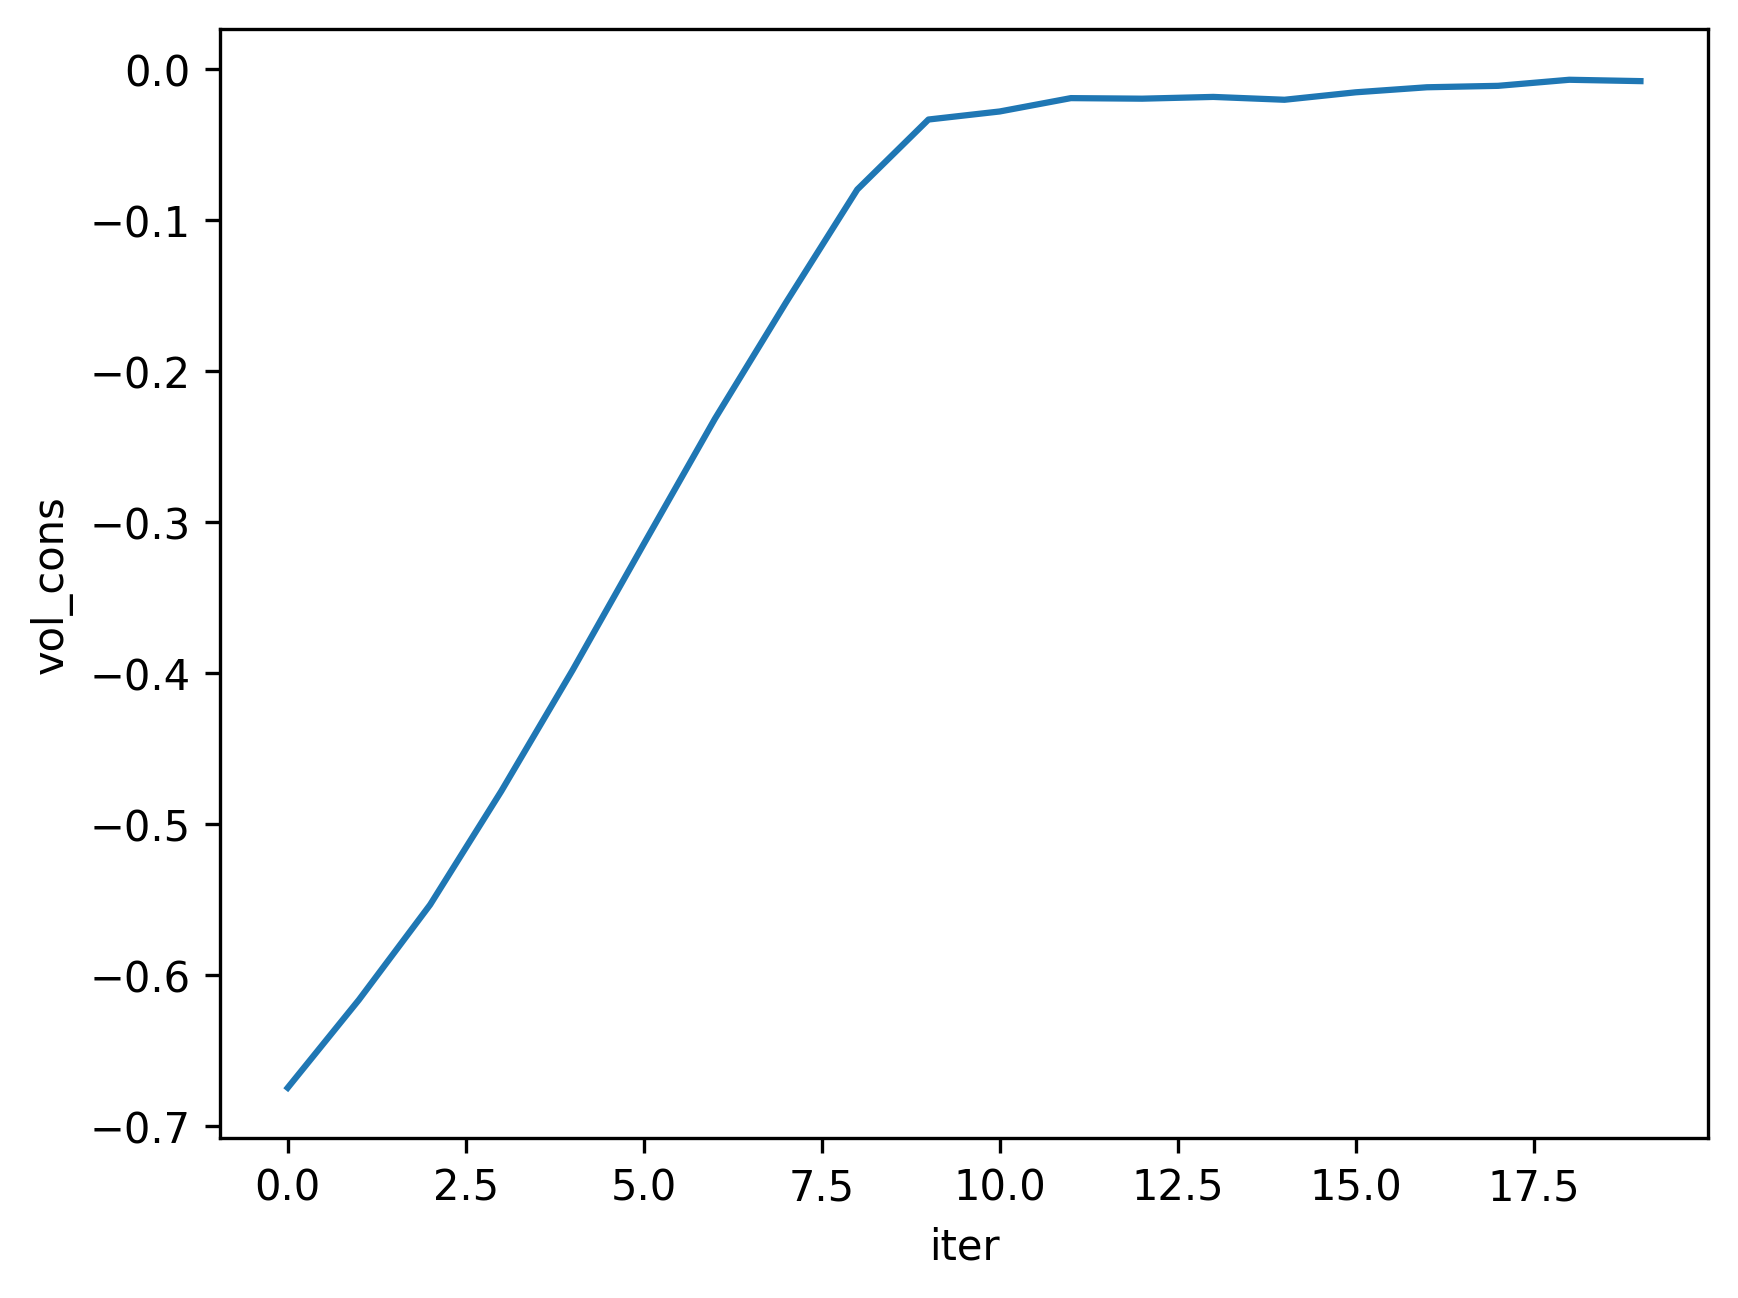

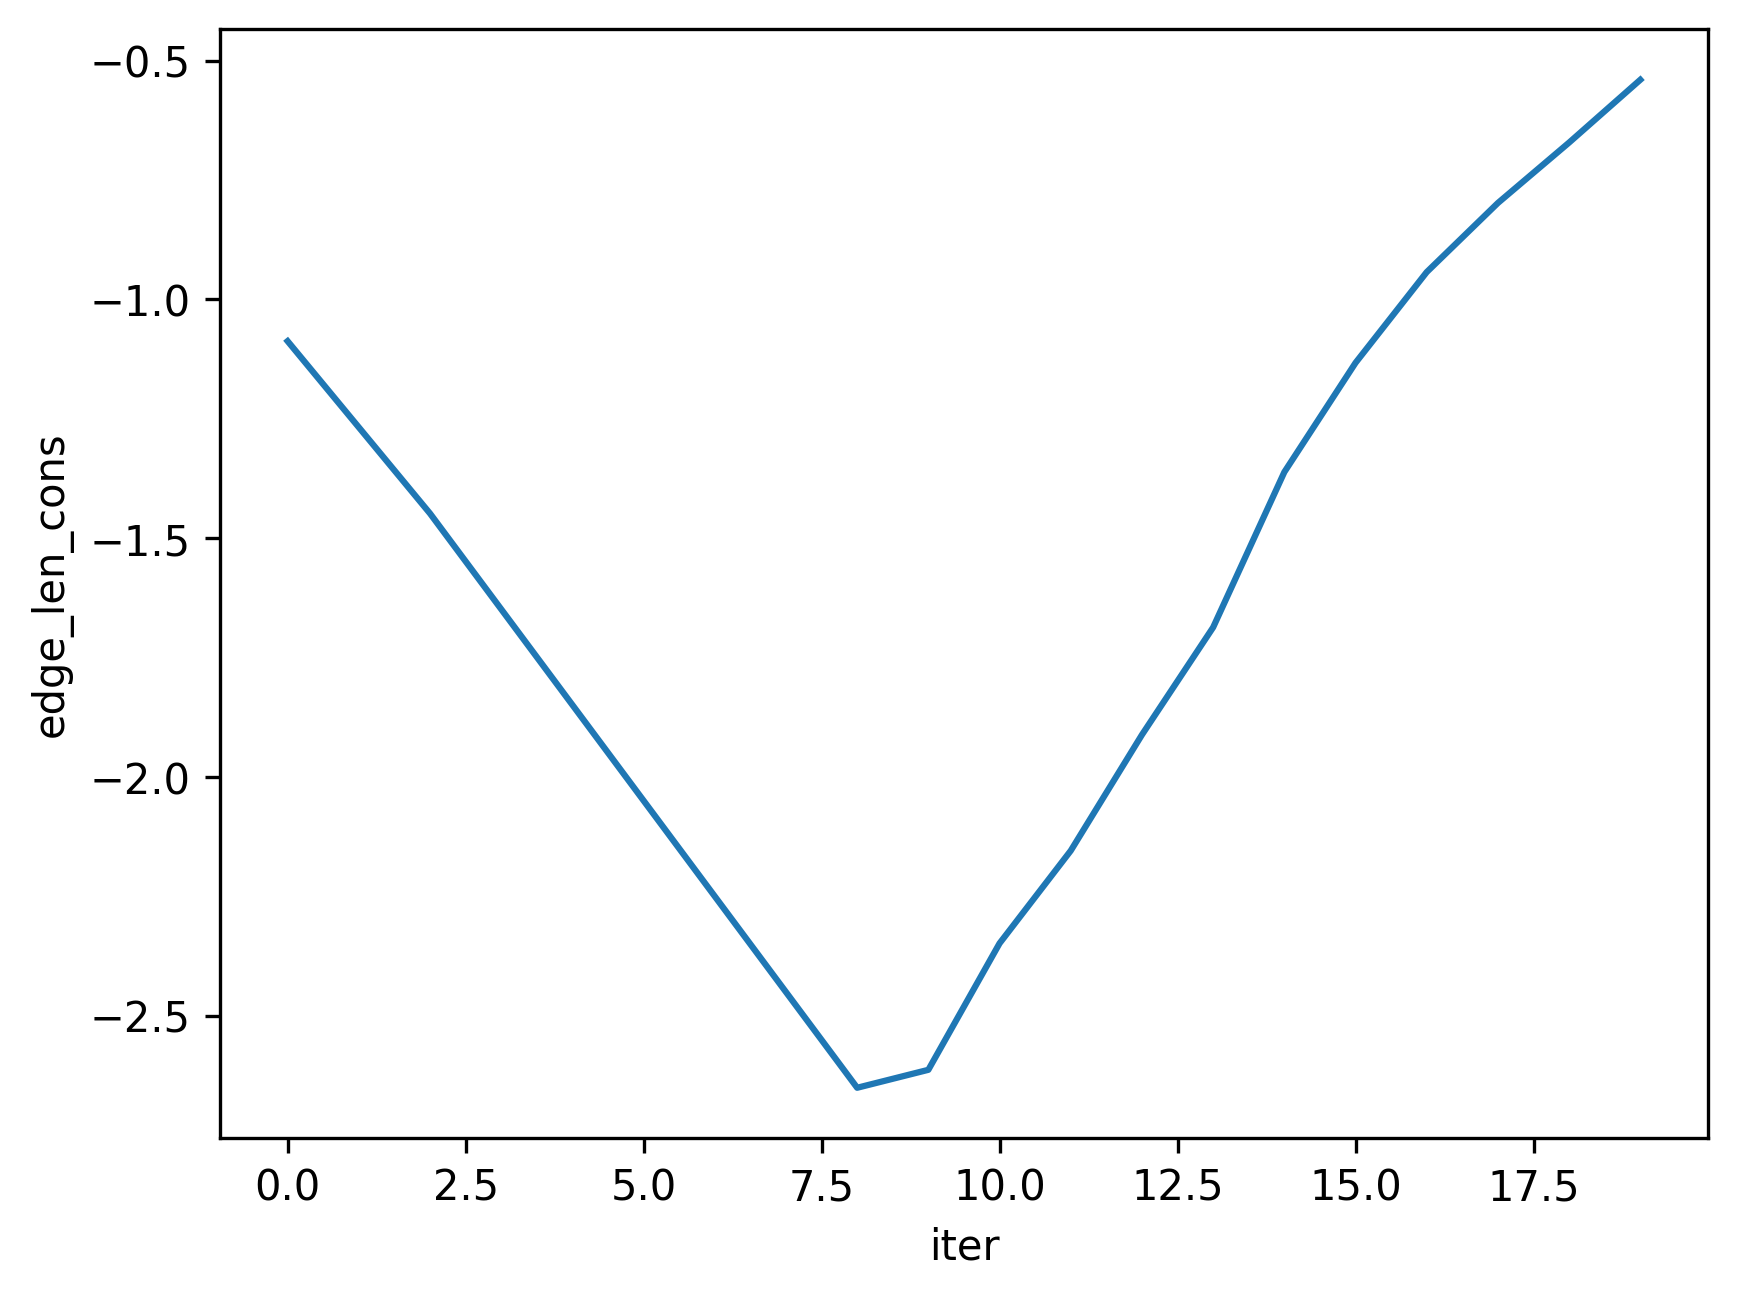

In [43]:
for k in history:
  plt.figure()
  plt.plot(history[k])
  plt.xlabel('iter')
  plt.ylabel(f'{k}')